<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import shutil, os
# shutil.rmtree("game_logs")
shutil.unpack_archive('game_logs.zip', './')
shutil.unpack_archive('validation.zip', './')
print(len(os.listdir('game_logs')))
print(len(os.listdir('validation')))
train_filenames = os.listdir('game_logs')
val_filenames = os.listdir('validation')
train_filenames.sort()
val_filenames.sort()
print(train_filenames[0], val_filenames[0])

28004
19122
316756.npz 316756.npz


In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [18]:
# Constants
T = 1 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [19]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size, randomize) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = randomize
    self.boards_per_game = 4
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join('game_logs',f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if self.randomize:
        index = np.random.choice(length, min(self.boards_per_game, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
    
    Y_new = []
    for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return np.array(inputs), np.array(Y_new)

In [20]:
batch_size = 32

training_generator = My_Custom_Generator(train_filenames, batch_size, True)
validation_generator = My_Custom_Generator(val_filenames, batch_size, False)

In [21]:
inputs = tf.keras.Input(shape=(8, 8, 14))
x1 = tf.keras.layers.LeakyReLU()(inputs)

x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(14, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(73, (3,3),activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 14)]   0           []                               
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 8, 8, 14)     0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 8, 8, 128)    16256       ['leaky_re_lu_4[0][0]']          
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 8, 8, 128)   512         ['conv2d_3[0][0]']               
 rmalization)                                                                               

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [23]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 10,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(1000 // batch_size)) # Use only 1000 samples for validation

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


875/875 [==============================] - 140s 160ms/step - loss: 2.0729e-04 - categorical_accuracy: 0.0849 - val_loss: 2.1575e-04 - val_categorical_accuracy: 0.0472
Epoch 2/10
875/875 [==============================] - 139s 158ms/step - loss: 1.9459e-04 - categorical_accuracy: 0.1677 - val_loss: 2.0825e-04 - val_categorical_accuracy: 0.0796
Epoch 3/10
875/875 [==============================] - 139s 159ms/step - loss: 1.8899e-04 - categorical_accuracy: 0.2025 - val_loss: 2.0790e-04 - val_categorical_accuracy: 0.0865
Epoch 4/10
875/875 [==============================] - 139s 158ms/step - loss: 1.8309e-04 - categorical_accuracy: 0.2360 - val_loss: 2.0506e-04 - val_categorical_accuracy: 0.1129
Epoch 5/10
875/875 [==============================] - 139s 159ms/step - loss: 1.7916e-04 - categorical_accuracy: 0.2609 - val_loss: 2.0560e-04 - val_categorical_accuracy: 0.1226
Epoch 6/10
875/875 [==============================] - 139s 158ms/step - loss: 1.7731e-04 - categorical_accuracy: 0.2715 -

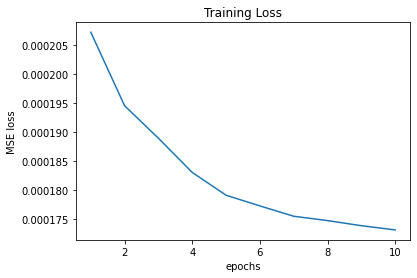

In [24]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

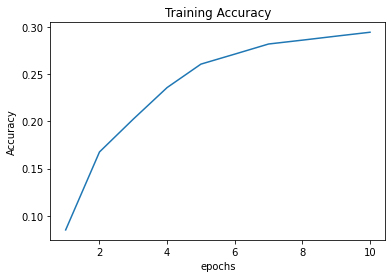

In [25]:
plt.title('Training Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['categorical_accuracy'])))),  history.history['categorical_accuracy'])

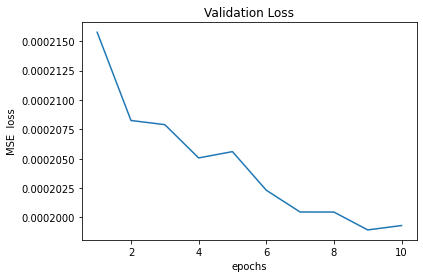

In [26]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('MSE  loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

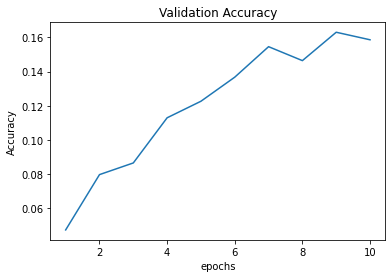

In [27]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_categorical_accuracy'])))),  history.history['val_categorical_accuracy'])

In [28]:
print(history.history)

{'loss': [0.00020728545496240258, 0.0001945939293364063, 0.00018899115093518049, 0.0001830909022828564, 0.00017915603530127555, 0.0001773134572431445, 0.00017552768986206502, 0.00017477701476309448, 0.0001738984719850123, 0.00017316901357844472], 'categorical_accuracy': [0.08488208055496216, 0.16765421628952026, 0.20253555476665497, 0.23603878915309906, 0.26092368364334106, 0.2715384066104889, 0.2822738289833069, 0.2863750755786896, 0.29061663150787354, 0.2947607636451721], 'val_loss': [0.0002157548733521253, 0.00020824943203479052, 0.00020789603877346963, 0.00020506448345258832, 0.0002056009543593973, 0.00020232021051924676, 0.0002004654670599848, 0.00020046123245265335, 0.00019894172146450728, 0.00019931519636884332], 'val_categorical_accuracy': [0.04724596440792084, 0.07962962985038757, 0.08646723628044128, 0.11291547864675522, 0.12260209023952484, 0.13670465350151062, 0.15455840528011322, 0.14639125764369965, 0.16301044821739197, 0.15859448909759521]}
